#### Objective : Univariate Time Series Modelling using DARTS for model training and weight & Biases for model logging to beat the becnhmark model already provided

#### Created By : Ashwini Kumar

#### Start Date : 16th March 2022

#### Steps Involved :

    1. Read the data from the csv file and split into train and validation splits 
    
    2. Define the Variables to be tuned and define the error function for benchmarking
    
    3. Define the Weight & Bias Initialization using API Key
    
    4. Use Sweep to do hyperparam tuning in the data
    
    5. Log the data to Weight & Bias to see the results

In [52]:
# Import the required packages 
from darts import TimeSeries
import pandas as pd
import tqdm as notebook_tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [53]:
# Function to read the csv file from given location & parse datetime properly

def load_dataframe(filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

# Call the function to read the data properly

df = load_dataframe("_Final_master_df_2022_2017_v9_with_Bolzano.csv")
df.head(5)

,Date,RequestedQTY,GoodsIssuedQTY,InvoicedQTY,PDO number,req_Illy,req_Teddy,req_Thun,req_other,inv_Illy,...,BOL_B2B AA Thun,BOL_B2B P&P Thun,BOL_B2B Sorter Thun,BOL_B2B Sorter SM Thun,BOL_B2B Sorter BVB Thun,BOL_B2B Sorter riassortimenti WHS,BOL_B2C Thun,BOL_B2C Sorter Thun,BOL_B2C P2L Thun,BOL_Inbound Thun
0,2016-12-26,1616.0,1613.0,1613.0,135,635.0,0.0,981.0,0.0,635.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,227928.0,217034.0,216049.0,12075,12851.0,0.0,215041.0,36.0,11866.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-09,176524.0,167839.0,166669.0,10663,14442.0,0.0,162078.0,4.0,13272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-16,289548.0,280089.0,279048.0,12330,14555.0,0.0,274961.0,32.0,13514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-23,248337.0,234044.0,232787.0,15942,15244.0,0.0,233063.0,30.0,13987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df.columns


Index(['Date', 'RequestedQTY', 'GoodsIssuedQTY', 'InvoicedQTY', 'PDO number',
       'req_Illy', 'req_Teddy', 'req_Thun', 'req_other', 'inv_Illy',
       'inv_Teddy', 'inv_Thun', 'inv_other', 'req_ThunB2B', 'req_ThunB2C',
       'req_ThunB2B_AA', 'req_ThunB2B_PP', 'req_ThunB2B_Sorter',
       'req_ThunB2B_Sort_BVB', 'req_ThunB2B_Sort_SM',
       'req_ThunB2B_SortSM_10more_no', 'req_ThunB2B_SortSM_10more_yes',
       'Thun_PDOs', 'req_BowlPros', 'inv_BowlPros', 'AVGperPDO_Thun_ReqQ',
       'AVGperPDO_Thun_SKU', 'AVGperPDOThunB2B_ReqQ', 'AVGperPDOThunB2B_InvQ',
       'AVGperPDOThunB2B_SKU', 'AVGperPDOThunB2B_PDOs',
       'AVGperPDOThunB2C_ReqQ', 'AVGperPDOThunB2C_InvQ',
       'AVGperPDOThunB2C_SKU', 'AVGperPDOThunB2C_PDOs',
       'AVGperPDOThunB2Bsort_ReqQ', 'AVGperPDOThunB2Bsort_InvQ',
       'AVGperPDOThunB2Bsort_SKU', 'ThunB2Bsort_PDOs',
       'AVGperPDOThunB2Bpp_ReqQ', 'AVGperPDOThunB2Bpp_InvQ',
       'AVGperPDOThunB2Bpp_SKU', 'ThunB2Bpp_PDOs', 'AVGperPDOThunB2Baa_ReqQ',
     

In [55]:
# Function create the Time Series from Dataframe using a function

def df_to_timeseries(df,time_column, timeseries):
    series = TimeSeries.from_dataframe(df, time_column,timeseries)
    return (series)

In [56]:
timeseries_input = df_to_timeseries(df,"Date","req_ThunB2B_Sorter")

benchmark_input = df_to_timeseries(df,"Date","BOL_B2B Sorter Thun")

In [57]:
# Set aside the data since 2021 
train_data, val_data = timeseries_input.split_before(pd.Timestamp('2021-01-04'))

train_benchmark_ignore, benchmark_data = benchmark_input.split_before(pd.Timestamp('2021-01-04'))

In [58]:
from darts.metrics import mae
def eval_error(actual_values,pred_values):
    return mae(actual_values,pred_values)

In [59]:
## Lets try a basic NBeats Model and see how it performs

In [72]:
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=32, output_chunk_length=4, n_epochs = 125, random_state = 0)

In [71]:
# fitting the model
model = model.fit(train_data, verbose = True)

[2022-03-20 19:06:26,292] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 175 samples.
[2022-03-20 19:06:26,292] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 175 samples.
[2022-03-20 19:06:26,356] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:06:26,356] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:06:26,357] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:06:26,357] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

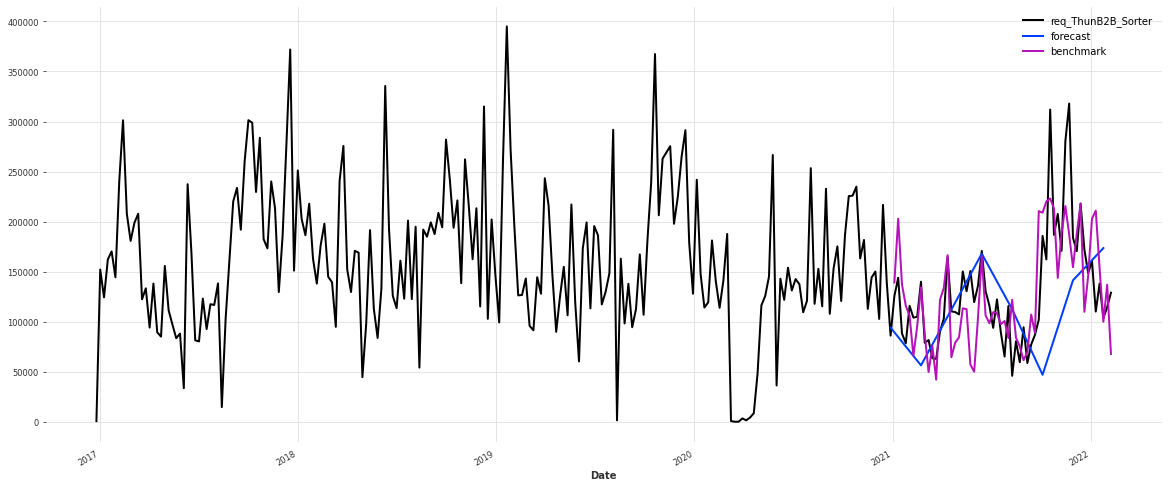

In [72]:
pred_series = model.historical_forecasts(
    timeseries_input,
    start=pd.Timestamp("2020-12-07"),
    forecast_horizon=4,
    stride=8,
    retrain=False,
    verbose=True,
)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)
timeseries_input.plot()
pred_series.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [73]:

print (eval_error(val_data,pred_series))

print (eval_error(val_data,benchmark_data))

57895.44830333375
33980.206896551725


Predicting: 6it [00:00, ?it/s]

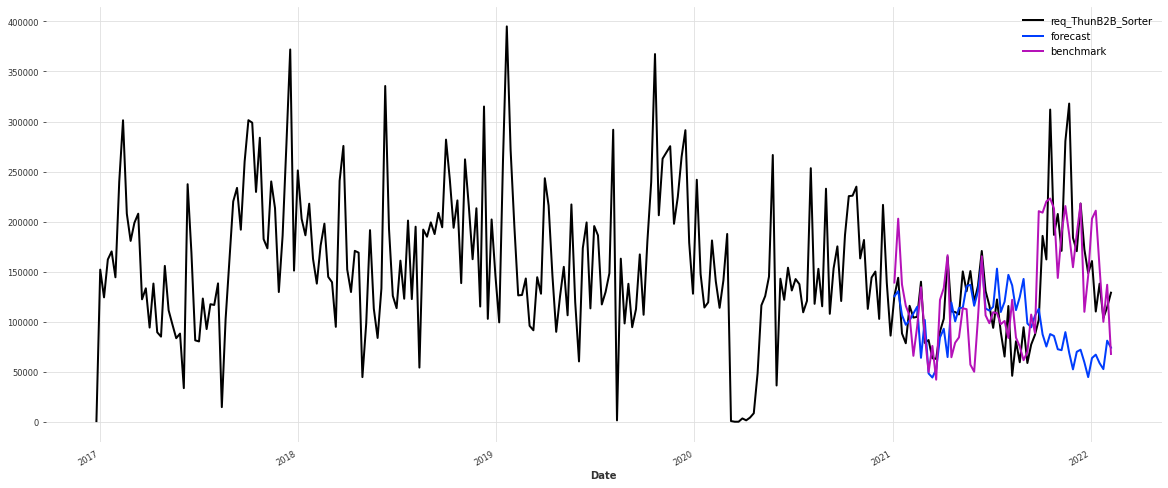

In [74]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)
timeseries_input.plot()
model.predict(n = 58, series = train_data).plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [75]:
## Lets Initialise the weight & biases and tune the hyperparams for Nbeats model to see how it performs

In [76]:
!pip install wandb -qqq
!pip install plotly
import wandb
import plotly

In [77]:
# Login to Weight & Biases 
wandb.login()

wandb: Currently logged in as: fibonacciash (use `wandb login --relogin` to force relogin)


True

In [78]:
## Initialise the Logging and start logging



In [79]:
# Define SWEEP function in DARTS and record all the hyperparams
wandb.init(project="TimeSeries", entity="fibonacciash")
sweep_config = {
  "name" : "my-sweep",
  "method" : "random",
  "parameters" : {
      "input_chunk_length" : {"values" : [8,16,24,32]},
      "output_chunk_length" : {"values" : [1,2,4,8,12]}
            
  }
}

sweep_id = wandb.sweep(sweep_config)
import pprint
pprint.pprint(sweep_config)

Create sweep with ID: nouew1aa
Sweep URL: https://wandb.ai/fibonacciash/uncategorized/sweeps/nouew1aa
{'method': 'random',
 'name': 'my-sweep',
 'parameters': {'input_chunk_length': {'values': [8, 16, 24, 32]},
                'output_chunk_length': {'values': [1, 2, 4, 8, 12]}}}


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jp8ytkz with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 12


[2022-03-20 19:12:06,797] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 191 samples.
[2022-03-20 19:12:06,797] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 191 samples.
[2022-03-20 19:12:06,808] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:12:06,808] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:12:06,810] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:12:06,810] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,72105.82678


wandb: Agent Starting Run: oo2h0l3z with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 4


[2022-03-20 19:12:50,077] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 199 samples.
[2022-03-20 19:12:50,077] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 199 samples.
[2022-03-20 19:12:50,085] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:12:50,085] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:12:50,087] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:12:50,087] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,74264.07688


wandb: Agent Starting Run: lb7qytv9 with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 1


[2022-03-20 19:13:33,137] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 178 samples.
[2022-03-20 19:13:33,137] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 178 samples.
[2022-03-20 19:13:33,144] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:13:33,144] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:13:33,145] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:13:33,145] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,59880.84418


wandb: Agent Starting Run: z70po8cj with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 2


[2022-03-20 19:14:16,039] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 201 samples.
[2022-03-20 19:14:16,039] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 201 samples.
[2022-03-20 19:14:16,046] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:14:16,046] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:14:16,047] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:14:16,047] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,56819.90416


wandb: Agent Starting Run: 3fil5x5y with config:
wandb: 	input_chunk_length: 16
wandb: 	output_chunk_length: 12


[2022-03-20 19:14:59,046] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 183 samples.
[2022-03-20 19:14:59,046] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 183 samples.
[2022-03-20 19:14:59,056] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:14:59,056] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:14:59,057] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:14:59,057] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,77433.93214


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ixuawr8k with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 2


[2022-03-20 19:15:46,365] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 201 samples.
[2022-03-20 19:15:46,365] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 201 samples.
[2022-03-20 19:15:46,373] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:15:46,373] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:15:46,375] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:15:46,375] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,56819.90416


wandb: Agent Starting Run: 712goh9p with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 12


[2022-03-20 19:16:30,711] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-20 19:16:30,711] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-20 19:16:30,722] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:16:30,722] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:16:30,723] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:16:30,723] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,54438.46009


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gd9nvy0r with config:
wandb: 	input_chunk_length: 16
wandb: 	output_chunk_length: 12


[2022-03-20 19:17:19,158] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 183 samples.
[2022-03-20 19:17:19,158] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 183 samples.
[2022-03-20 19:17:19,166] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:17:19,166] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:17:19,167] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:17:19,167] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,77433.93214


wandb: Agent Starting Run: 5q5xoals with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 4


[2022-03-20 19:18:03,251] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 175 samples.
[2022-03-20 19:18:03,251] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 175 samples.
[2022-03-20 19:18:03,261] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:18:03,261] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:18:03,264] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:18:03,264] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,55730.88736


wandb: Agent Starting Run: wj8qyk15 with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 12


[2022-03-20 19:18:46,383] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-20 19:18:46,383] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-20 19:18:46,392] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:18:46,392] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:18:46,393] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:18:46,393] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,54438.46009


wandb: Agent Starting Run: eoo9qrxy with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 2


[2022-03-20 19:19:25,637] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 177 samples.
[2022-03-20 19:19:25,637] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 177 samples.
[2022-03-20 19:19:25,647] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:19:25,647] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:19:25,648] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:19:25,648] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,56329.10798


wandb: Agent Starting Run: ja07mh53 with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 2


[2022-03-20 19:20:08,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 177 samples.
[2022-03-20 19:20:08,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 177 samples.
[2022-03-20 19:20:08,883] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:20:08,883] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:20:08,884] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:20:08,884] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,56329.10798


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m1rrdz8e with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 2


[2022-03-20 19:20:56,368] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 201 samples.
[2022-03-20 19:20:56,368] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 201 samples.
[2022-03-20 19:20:56,376] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:20:56,376] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:20:56,376] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:20:56,376] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,56819.90416


wandb: Agent Starting Run: 6nl4bh5l with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 8


[2022-03-20 19:21:40,294] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-20 19:21:40,294] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-20 19:21:40,302] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:21:40,302] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:21:40,307] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:21:40,307] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,53405.01407


wandb: Agent Starting Run: 55jlzc6g with config:
wandb: 	input_chunk_length: 24
wandb: 	output_chunk_length: 8


[2022-03-20 19:22:23,224] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 179 samples.
[2022-03-20 19:22:23,224] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 179 samples.
[2022-03-20 19:22:23,231] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:22:23,231] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:22:23,233] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:22:23,233] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,60980.8121


wandb: Agent Starting Run: wwv9p65e with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 12


[2022-03-20 19:23:50,061] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-20 19:23:50,061] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-20 19:23:50,069] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:23:50,069] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:23:50,070] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:23:50,070] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,54438.46009


wandb: Agent Starting Run: i4j5y5gk with config:
wandb: 	input_chunk_length: 32
wandb: 	output_chunk_length: 1


[2022-03-20 19:24:33,304] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 178 samples.
[2022-03-20 19:24:33,304] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 178 samples.
[2022-03-20 19:24:33,312] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:24:33,312] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:24:33,313] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:24:33,313] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,59880.84418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aw8yyda1 with config:
wandb: 	input_chunk_length: 16
wandb: 	output_chunk_length: 1


[2022-03-20 19:25:21,081] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-03-20 19:25:21,081] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-03-20 19:25:21,089] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:25:21,089] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:25:21,090] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:25:21,090] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,58244.01656


wandb: Agent Starting Run: 2rbh5s4e with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 12


[2022-03-20 19:26:04,553] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 191 samples.
[2022-03-20 19:26:04,553] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 191 samples.
[2022-03-20 19:26:04,562] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:26:04,562] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:26:04,564] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:26:04,564] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,72105.82678


wandb: Agent Starting Run: s1lx9a2i with config:
wandb: 	input_chunk_length: 8
wandb: 	output_chunk_length: 8


[2022-03-20 19:26:47,703] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 195 samples.
[2022-03-20 19:26:47,703] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 195 samples.
[2022-03-20 19:26:47,710] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:26:47,710] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:26:47,711] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:26:47,711] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

epoch,▁▁
loss_benchmark,▁
loss_train,▁
epoch,120
loss_benchmark,33980.2069
loss_train,73952.15446


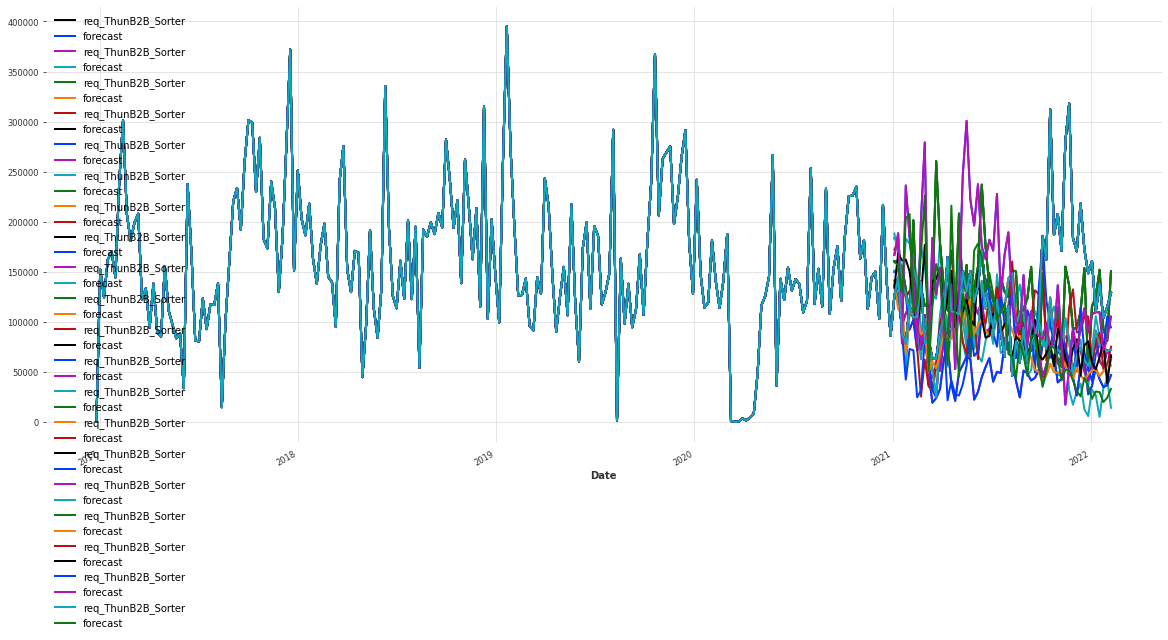

In [81]:
wandb.init(project="TimeSeries", entity="fibonacciash")
def train():
    with wandb.init() as run:
        config = wandb.config

       
 # your model training code here
        for epoch in [120]:
            model = NBEATSModel(input_chunk_length=config.input_chunk_length , output_chunk_length=config.output_chunk_length,
                                n_epochs = epoch,   generic_architecture=False,
                                num_blocks=3,num_layers=4,random_state = 15)
            
            # fitting the model
            model_req = model.fit(train_data, verbose = True)
            
            pred_air = model_req.predict(n = 58, series = train_data)


            loss = mae(val_data , pred_air)
            
            loss_benchmark = mae(val_data, benchmark_data)
            ## Log the absolute Error
            wandb.log({"loss_train": loss, "epoch": epoch})  
            ## 
            wandb.log({"loss_benchmark": loss_benchmark, "epoch": epoch})   
            plt.rcParams["figure.figsize"] = (20,8)
            timeseries_input.plot()
            model.predict(n = 58, series = train_data).plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
           
            plt.legend()
            plot_image = wandb.Image(plt)
            wandb.log({"chart" : plot_image})

count = 20 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

In [82]:
### N beats Model is not working in our scenario Lets test GRU Model

(True, 4)

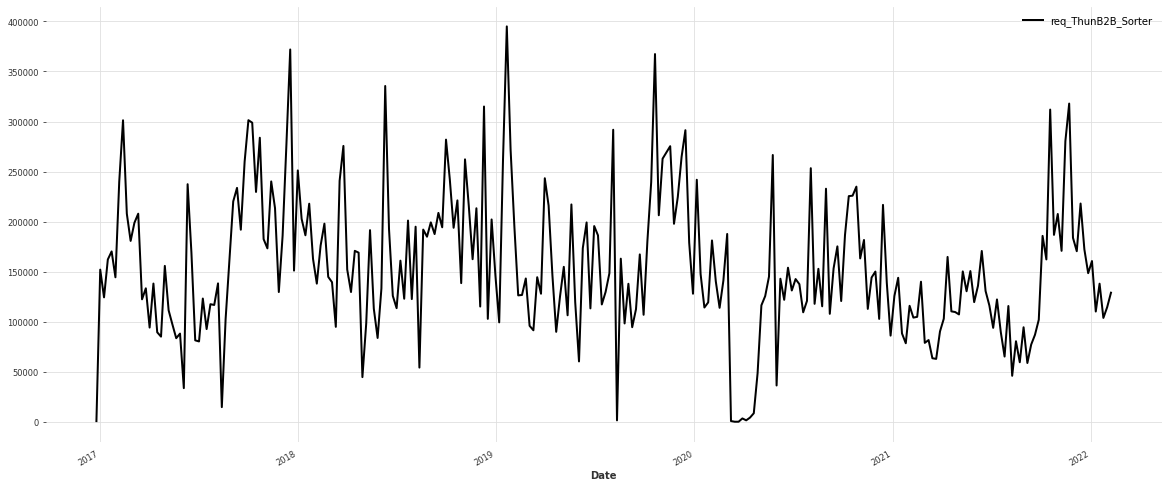

In [83]:
timeseries_input.plot()
check_seasonality( timeseries_input, max_lag=54)

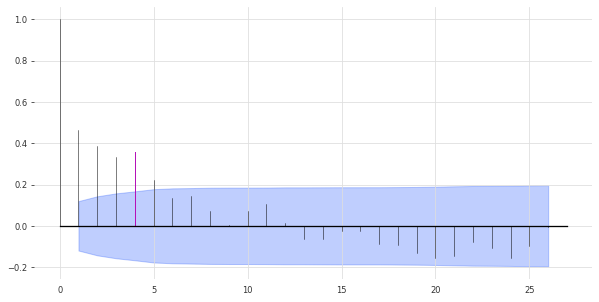

In [84]:
plot_acf(timeseries_input, 4, max_lag=26) 

In [98]:
my_model_sun = BlockRNNModel(
    model="GRU",
    input_chunk_length=126,
    output_chunk_length=4,
    hidden_size=10,
    n_rnn_layers=3,
    batch_size=128,
    n_epochs=100,
    dropout=0.1,
    model_name="sun_GRU",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
)

my_model_sun.fit(train_data, verbose=True)

[2022-03-20 19:44:51,423] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 81 samples.
[2022-03-20 19:44:51,423] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 81 samples.
[2022-03-20 19:44:51,427] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:44:51,427] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:44:51,428] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:44:51,428] WARNING | darts.models.forecasting.torch_forecasting_model | Deprecati

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

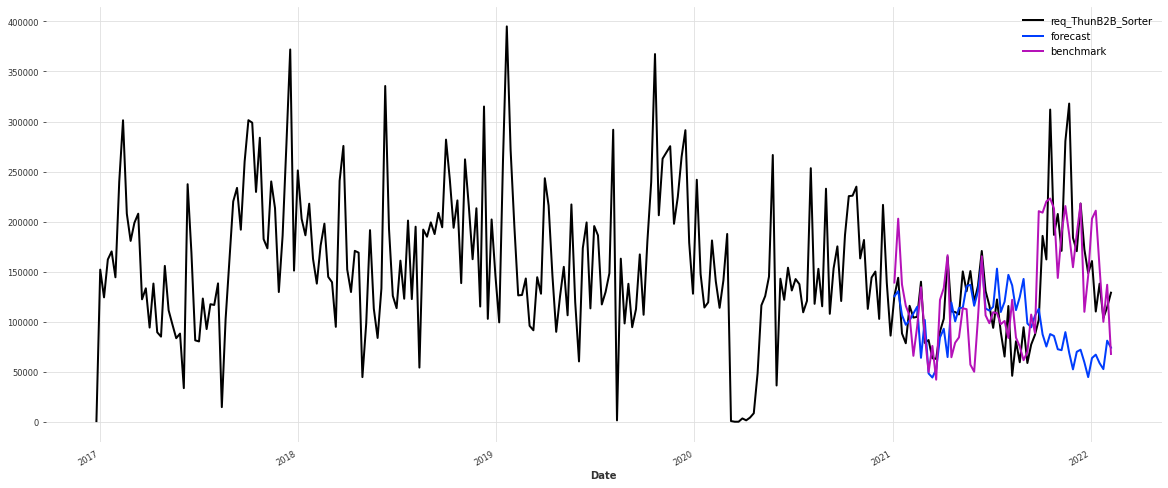

In [99]:

plt.rcParams["figure.figsize"] = (20,8)
timeseries_input.plot()
model.predict(n = 58, series =train_data).plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [20]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train_data)
prediction = model.predict(58, num_samples=10000)

C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


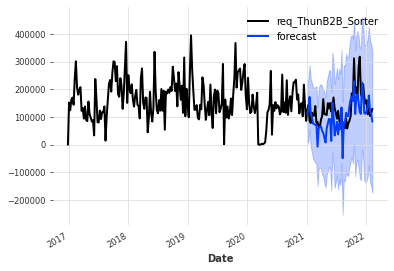

In [21]:
import matplotlib.pyplot as plt

timeseries_input.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [22]:
print (eval_error(val_data,prediction))

print (eval_error(val_data,benchmark_data))

47703.133576079745
33980.206896551725


In [40]:

from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
model = FFT(required_matches=set(),trend="poly")
model.fit(train_data)
prediction = model.predict(58)

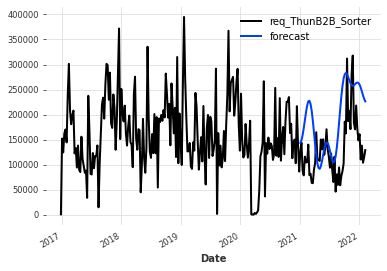

In [41]:
timeseries_input.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [42]:
print (eval_error(val_data,prediction))

print (eval_error(val_data,benchmark_data))

73239.88746575262
33980.206896551725


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


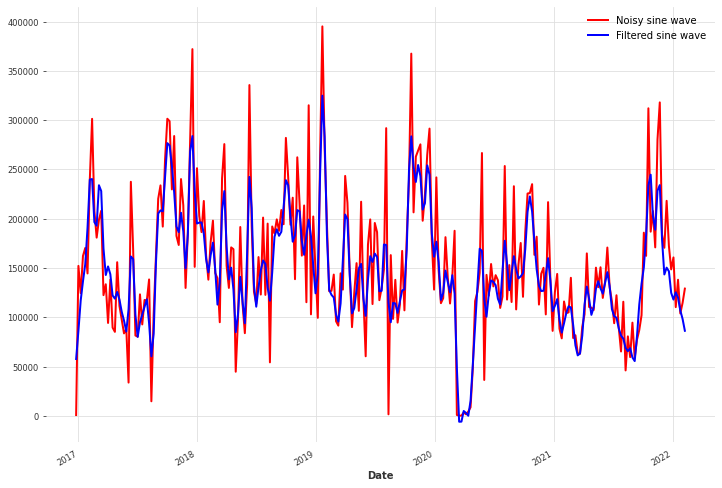

In [60]:
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF
from darts.models import GaussianProcessFilter
kernel = ExpSineSquared()
# kernel = RBF()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=0.4 / 2, n_restarts_optimizer=100
)
filtered_x = gpf.filter(timeseries_input)

plt.figure(figsize=[12, 8])

timeseries_input.plot(color="red", label="Noisy sine wave")
filtered_x.plot(color="blue", label="Filtered sine wave")
plt.legend()

In [61]:
train_data_filter, val_data_filter = filtered_x.split_before(pd.Timestamp('2021-01-04'))

In [68]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train_data_filter)
prediction = model.predict(58, num_samples=10000)

C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


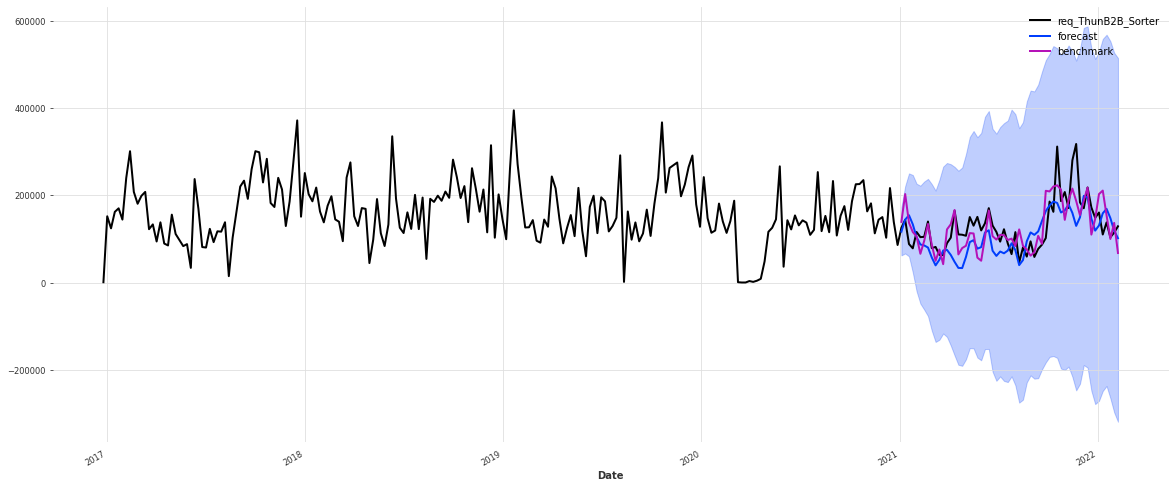

In [79]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)
timeseries_input.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [80]:
print (eval_error(val_data,prediction))

print (eval_error(val_data,benchmark_data))

41637.66412792171
33980.206896551725


In [76]:
model = NBEATSModel(input_chunk_length=32, output_chunk_length=8, n_epochs = 125, random_state = 0)
# fitting the model
model = model.fit(train_data_filter, verbose = True)

[2022-03-21 15:05:09,317] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-21 15:05:09,317] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-21 15:05:09,412] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 15:05:09,412] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 15:05:09,414] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-21 15:05:09,414] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

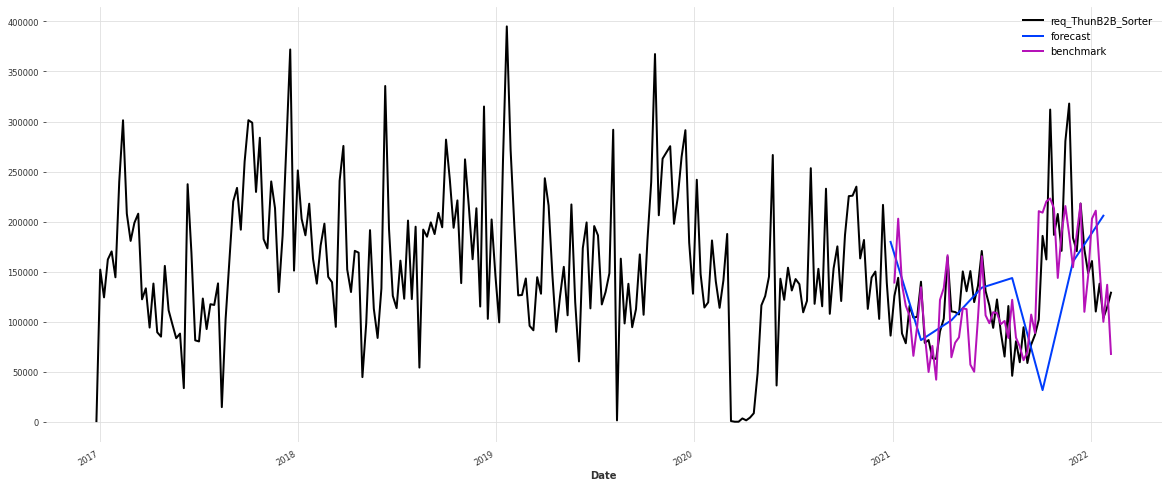

In [77]:
pred_series = model.historical_forecasts(
    timeseries_input,
    start=pd.Timestamp("2020-12-07"),
    forecast_horizon=4,
    stride=8,
    retrain=False,
    verbose=True,
)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)
timeseries_input.plot()
pred_series.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
plt.legend()

Predicting: 6it [00:00, ?it/s]

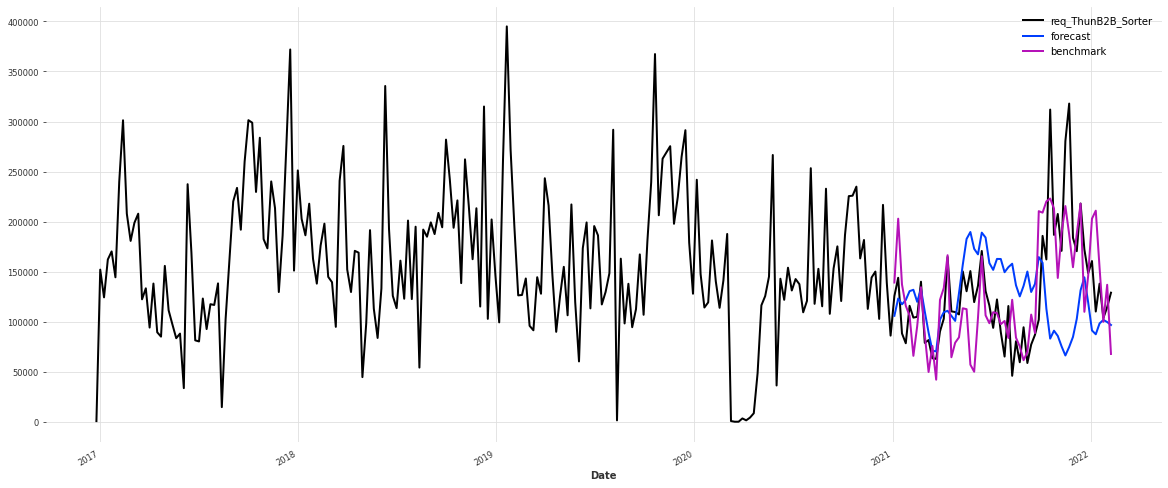

In [78]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)
timeseries_input.plot()
model.predict(n = 58, series = train_data).plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
plt.legend()